In [1]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

In [2]:
np.random.seed(177)

rho = 0.8
jumpVar = 1
nSamples = 10000

pdf_to_sample = ss.multivariate_normal(mean=np.array([2,1]), 
                                       cov=np.array([[1,rho],[rho,1]])).pdf

jump_dist = ss.multivariate_normal(mean=[0,0], cov=jumpVar)

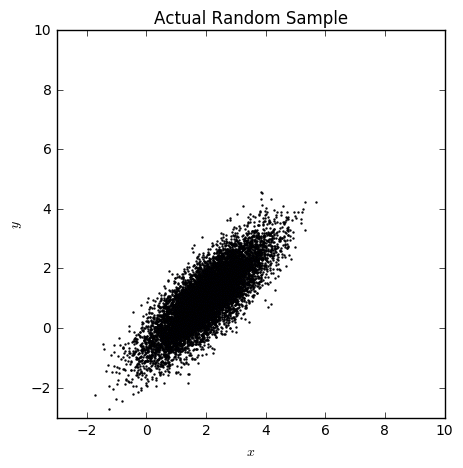

In [3]:
samp = ss.multivariate_normal(mean=np.array([2,1]), 
                                       cov=np.array([[1,rho],[rho,1]])).rvs(nSamples)
plt.figure(1,figsize=[5,5])
plt.scatter(samp[:,0], samp[:,1], s=.5)
plt.xlim([-3,10]); plt.ylim([-3,10])
plt.title("Actual Random Sample")
plt.xlabel("$x$"); plt.ylabel("$y$")

plt.show()

In [4]:
def metropolis(PDF, jump_distribution, num_samples, initial_point):
    sampled_points = np.array([initial_point])

    for i in range(num_samples-1):
        prev_sample = sampled_points[-1] 
        candidate_sample = sampled_points[-1] + jump_distribution.rvs(1)

        r = PDF(candidate_sample)/PDF(prev_sample)

        rand_unif = ss.uniform(0,1).rvs(1)[0]

        if rand_unif < r:
            sampled_points = np.append(sampled_points, np.array([candidate_sample]), axis=0)
        else:
            sampled_points = np.append(sampled_points, np.array([prev_sample]), axis=0)
    
    return sampled_points

In [5]:
sampled_points = metropolis(pdf_to_sample, jump_dist, nSamples, np.array([1,10]))

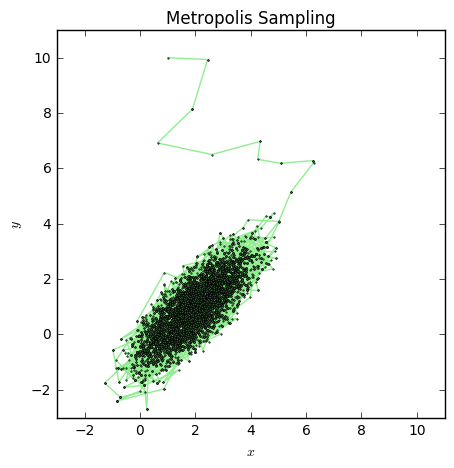

In [6]:
plt.figure(2,figsize=[5,5])
plt.plot(sampled_points[:,0],sampled_points[:,1], "-o", color="lightgreen", lw=1, ms=1)
plt.xlim([-3,11]); plt.ylim([-3,11])
plt.title("Metropolis Sampling")
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.show()

So this looks good except for the first few samples that cause the tail in the upper right portion of the scatter plot. To remove this we need to choose a better initial value but in reality it can be hard to do so. Another option is to add a burn in, which simply removes the first few samples. Let's add this to the metropolis function. 

In [7]:
def metropolis(PDF, jump_distribution, num_samples, initial_point, burn_in=0):
    sampled_points = np.array([initial_point])

    for i in range(num_samples + burn_in - 1):
        prev_sample = sampled_points[-1] 
        candidate_sample = sampled_points[-1] + jump_distribution.rvs(1)

        r = PDF(candidate_sample)/PDF(prev_sample)

        rand_unif = ss.uniform(0,1).rvs(1)[0]

        if rand_unif < r:
            sampled_points = np.append(sampled_points, np.array([candidate_sample]), axis=0)
        else:
            sampled_points = np.append(sampled_points, np.array([prev_sample]), axis=0)
    
    return sampled_points[burn_in:(num_samples+burn_in)]

With that coded up, let's look at what the sample looks like with a burn-in of 100 steps. 

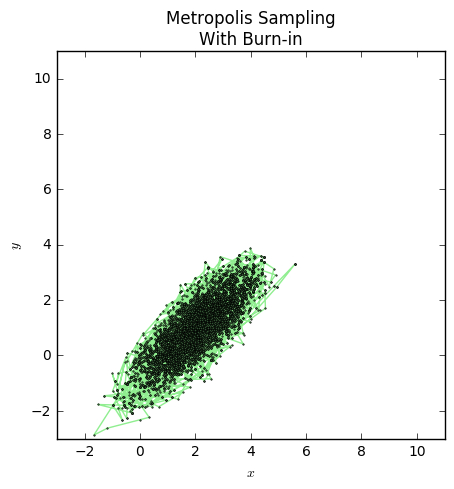

In [8]:
sampled_points = metropolis(pdf_to_sample, jump_dist, nSamples, np.array([1,10]), burn_in=100)

plt.figure(3,figsize=[5,5])
plt.plot(sampled_points[:,0],sampled_points[:,1], "-o", color="lightgreen", lw=1, ms=1)
plt.xlim([-3,11]); plt.ylim([-3,11])
plt.title("Metropolis Sampling\nWith Burn-in")
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.show()

### Checking Convergence
To check convergence, we can look at a single dimension and see how the values change with respect to time. If we are in the correct region all values will bounce around the same values and we should get something that looks like a stationary time series. Lets do plot the two dimensions now.

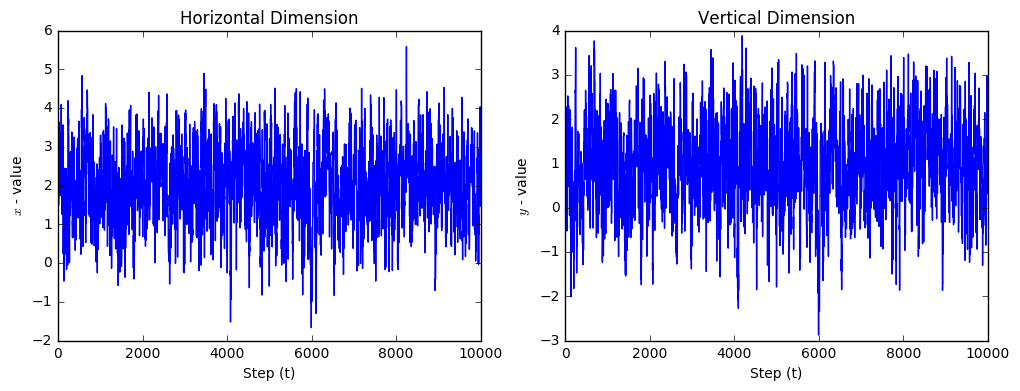

In [9]:
plt.figure(4, figsize=[12,4])

def plot_series(sampled_points):
    plt.subplot(1,2,1)
    plt.plot(np.arange(nSamples), sampled_points[:,0])
    plt.xlabel("Step (t)")
    plt.ylabel("$x$ - value")
    plt.title("Horizontal Dimension")

    plt.subplot(1,2,2)
    plt.plot(np.arange(nSamples), sampled_points[:,1])
    plt.xlabel("Step (t)")
    plt.ylabel("$y$ - value")
    plt.title("Vertical Dimension")

    plt.show()

plot_series(sampled_points)

These both look stationary and so we can conclude that the Metropolis algorithm gave a good sampling. There are many statistical tests to check for stationarity. At this point I want to explore what happens when you choose a bad jump distribution.

### If The Jump Distribution Is Too Small
This examples so far looks good by choosing a jump distribution of a bivariate gaussian. Choosing a Gaussian with mean of zero is a good choice with the Metropolis algorithm. The only question is how to choose the variance. a varaince of 1 worked well in the previous examples, but lets look at what happens when we choose the variance to be too small. e.g. 0.001

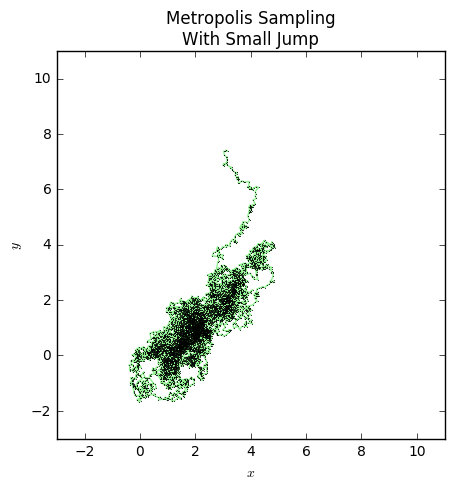

In [10]:
small_jump = ss.multivariate_normal(mean=[0,0], cov=0.005)

small_sampled_points = metropolis(pdf_to_sample, small_jump, 
                                  nSamples, np.array([1,10]), burn_in=100)
plt.figure(5,figsize=[5,5])
plt.plot(small_sampled_points[:,0],small_sampled_points[:,1], 
         "-o", color="lightgreen", lw=1, ms=.25)
plt.xlim([-3,11]); plt.ylim([-3,11])
plt.title("Metropolis Sampling\nWith Small Jump")
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.show()

When the step size is too small it will take too long to converge to the probability distribution. As we can see in the plot the convergence is too slow and even with a burn in, it still has a large tail. Moreover, the samples are clumped togehter because there are not enough iterations to cover enough of the distribution. So clearly we don't want too small of a jump. If we look a the corresponding series for each dimension, we see that it is not stationary.

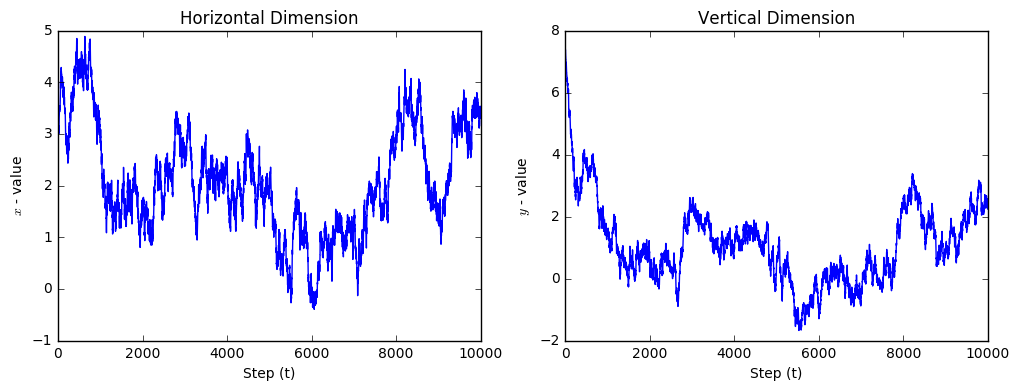

In [11]:
plt.figure(6, figsize=[12,4])
plot_series(small_sampled_points)

So too small of a jump does not give a random sample.

### If The Jump Distribution Is Too Large
Too large of a jump can be a problem as well. If we have too large of a jump the setp size will shoot out to a low probability spot making it more likely to get rejected. This will cause a lot of clumping at single point is the sapce. Let's use a variance of 100 to demonstrate this.

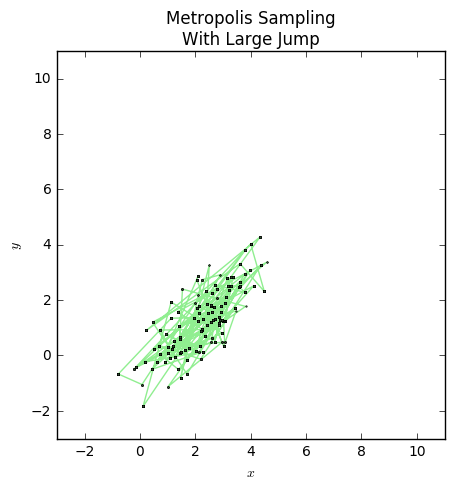

In [12]:
big_jump = ss.multivariate_normal(mean=[0,0], cov=100)

big_sampled_points = metropolis(pdf_to_sample, big_jump, 
                                nSamples, np.array([1,10]), burn_in=100)

plt.figure(7,figsize=[5,5])
plt.plot(big_sampled_points[:,0],big_sampled_points[:,1], 
         "-o", color="lightgreen", lw=1, ms=1)
plt.xlim([-3,11]); plt.ylim([-3,11])
plt.title("Metropolis Sampling\nWith Large Jump")
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.show()

This is the same number of points, but since the steps are getting rejected so often that many of the points are stacked on top of each other. This does not give us enough movement to accurately sample the space. 

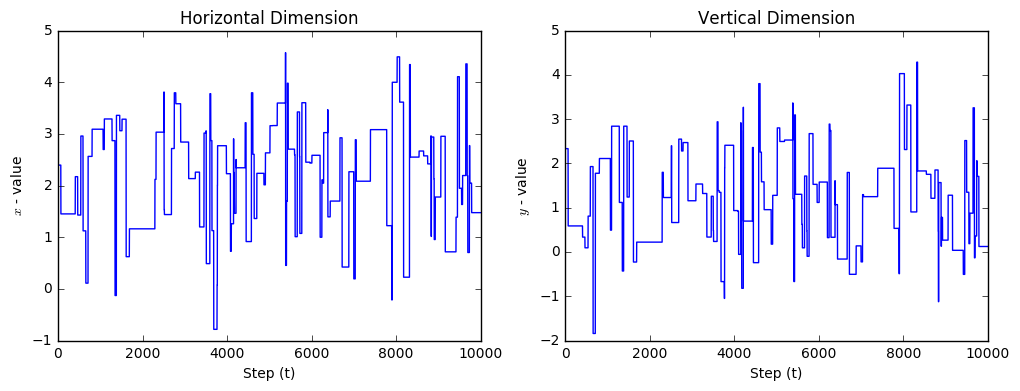

In [13]:
plt.figure(8, figsize=[12,4])
plot_series(big_sampled_points)

We can see that this does not give a good sampling since it goes for long stretches where the value does not change. Therefore, too large of a jump also doesn't work because it acts as if certain values have high probabilities (because they occur so frequently) when in reality they do not.